### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import seaborn as sns

import metabolinks as mtl
import metabolinks.transformations as transf

import multianalysis as ma
from elips import plot_confidence_ellipse

In [2]:
%matplotlib inline

### Function to read the aligned files made with the align function (old version) of metabolinks

In [3]:
def read_aligned_files(filename):
    """Read aligned peak lists while moving label level in the columns index to position 0."""
    df = pd.read_csv(filename, header=[0,1], index_col=[0])
    df.columns = df.columns.swaplevel(0,1)
    df.index.name = 'm/z'
    return df

## Alignment chosen

2-1 was the alignment chosen despite the artifical cluster of replicates, since no other totally unbiased alignments managed perfect clustering of all replicates of all varieties as requested from the ones seen so far. Other alignments are still being tested. 

So far no unbiased alignments was able to correctly cluster more than 8 grapevine varieties (maximum of 13).

In [4]:
data_pos = pd.HDFStore('alignments.h5').get('groups_1ppm_min2_all_1ppm_pos_clean')
data_neg = pd.HDFStore('alignments.h5').get('groups_1ppm_min2_all_1ppm_neg_clean')
data_neg

label             CAN                              CS                        \
                   14        15         16         29         30         31   
97.588690         NaN       NaN        NaN        NaN        NaN        NaN   
97.588872   1557223.0  468344.0  2070914.0  1451682.0  1980895.0  1453977.0   
97.590018         NaN       NaN        NaN        NaN        NaN        NaN   
97.590194   1031039.0  321586.0        NaN   726879.0  1021593.0   724833.0   
97.591876    903612.0  296777.0   916971.0   631419.0   738122.0   704010.0   
...               ...       ...        ...        ...        ...        ...   
966.054730        NaN       NaN        NaN        NaN        NaN        NaN   
966.057615        NaN       NaN        NaN        NaN        NaN        NaN   
966.144500        NaN       NaN        NaN  1024758.0   992789.0        NaN   
966.244942        NaN       NaN        NaN        NaN        NaN        NaN   
977.114035        NaN       NaN        NaN        NaN        NaN        NaN   

label            LAB                             PN  ...        TRI     CFN  \
                   8         9         10        23  ...         34 10713-1   
97.588690        NaN       NaN        NaN       NaN  ...  2197036.0     NaN   
97.588872   636114.0  998914.0  1257923.0  709044.0  ...        NaN     NaN   
97.590018        NaN       NaN        NaN       NaN  ...  1421899.0     NaN   
97.590194        NaN       NaN        NaN       NaN  ...        NaN     NaN   
97.591876   331444.0  530601.0   538030.0       NaN  ...  1176756.0     NaN   
...              ...       ...        ...       ...  ...        ...     ...   
966.054730       NaN       NaN        NaN       NaN  ...        NaN     NaN   
966.057615       NaN       NaN        NaN       NaN  ...        NaN     NaN   
966.144500       NaN       NaN        NaN       NaN  ...        NaN     NaN   
966.244942       NaN       NaN        NaN       NaN  ...        NaN     NaN   
977.114035       NaN       NaN        NaN       NaN  ...        NaN     NaN   

label                          CHT                      SB                  
           10713-2 10713-3 13514-1 13514-2 13514-3 53211-1 53211-2 53211-3  
97.588690      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
97.588872      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
97.590018      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
97.590194      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
97.591876      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
...            ...     ...     ...     ...     ...     ...     ...     ...  
966.054730     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
966.057615     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
966.144500     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
966.244942     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
977.114035     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  

[3145 rows x 42 columns]

In [5]:
# remove varieties CFN CHT SB
data_pos = data_pos.drop(['CFN', 'CHT', 'SB', 'RU'], axis='columns', level=0)
data_neg = data_neg.drop(['CFN', 'CHT', 'SB', 'RU'], axis='columns', level=0)

### Order non-vinifera then vinifera

In [6]:
vin = ['REG', 'PN', 'RL', 'CS', 'TRI']
nonvin = [c for c in pd.unique(data_pos.columns.get_level_values(0)) if c not in vin]
neworder = nonvin + vin
data_pos = data_pos[neworder]
data_neg = data_neg[neworder]
data_pos.columns

MultiIndex([('CAN', '14'),
            ('CAN', '15'),
            ('CAN', '16'),
            ('LAB',  '8'),
            ('LAB',  '9'),
            ('LAB', '10'),
            ('RIP', '17'),
            ('RIP', '18'),
            ('RIP', '19'),
            ('ROT', '20'),
            ('ROT', '21'),
            ('ROT', '22'),
            ('SYL', '11'),
            ('SYL', '12'),
            ('SYL', '13'),
            ('REG', '38'),
            ('REG', '39'),
            ('REG', '40'),
            ( 'PN', '23'),
            ( 'PN', '24'),
            ( 'PN', '25'),
            ( 'RL', '26'),
            ( 'RL', '27'),
            ( 'RL', '28'),
            ( 'CS', '29'),
            ( 'CS', '30'),
            ( 'CS', '31'),
            ('TRI', '32'),
            ('TRI', '33'),
            ('TRI', '34')],
           names=['label', None])

## Dendogram HCA plotting

In [7]:
def perform_HCA(df, metric='euclidean', method='average', return_coph=False):
    distances = dist.pdist(df.T, metric=metric)
    Z = hier.linkage(distances, method=method) #ward, average, centroid, single, complete, weighted, median

    #Cophenetic Correlation Coefficient (see how the clustering - from hier.linkage - preserves the original distances)
    coph = hier.cophenet(Z, distances)[0]
    if return_coph:
        return (Z, coph)
    else:
        return Z

In [8]:
def plot_dendogram(Z, label_colors, title='', ax=None):
    if ax is None:
        ax = plt.gca()
    dn = hier.dendrogram(Z, labels=all_labels, leaf_font_size=15, above_threshold_color='b', ax=ax)
    #Coloring labels
    ax.set_ylabel('Distance (UA)')
    ax.set_title(title, fontsize = 15)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        lbl.set_color(label_colors[lbl.get_text()])

## PCA

In [9]:
def compute_df_with_PCs(df, return_var_ratios=False):
    df_data = df.cdl.data
    # DataParts = namedtuple('DataParts', 'data_matrix labels names features unique_labels')

    # Perform PCA
    n_components = 5
    pca = PCA(n_components=n_components)
    pc_coords = pca.fit_transform(df_data.data_matrix)
    var_explained = pca.explained_variance_ratio_[:n_components]

    # concat labels to PCA coords (in a DataFrame)
    pc_coords = pd.DataFrame(pc_coords, columns=[f'PC {i}' for i in range(1, n_components+1)])
    labels_col = pd.DataFrame(df_data.labels, columns=['Label'])
    principaldf = pd.concat([pc_coords, labels_col], axis=1)
    if not return_var_ratios:
        return principaldf
    else:
        return principaldf, var_explained

def plot_PCA(principaldf, label_colors, components=(1,2), var_explained=None, title="PCA", ax=None):
    if ax is None:
        ax = pl.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    with sns.axes_style("whitegrid"):
        ax.axis('equal')
        if var_explained is not None:
            v1, v2 = var_explained[loc_c1], var_explained[loc_c2]
            ax.set_xlabel(f'{col_c1_name} ({100*v1:.1f}%)', fontsize = 15)
            ax.set_ylabel(f'{col_c2_name} ({100*v2:.1f}%)', fontsize = 15)
        else:
            ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
            ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

        unique_labels = principaldf['Label'].unique()

        for lbl in unique_labels:
            subset = principaldf[principaldf['Label']==lbl]
            ax.scatter(subset[col_c1_name],
                       subset[col_c2_name],
                       s=50, color=label_colors[lbl], label=lbl)

        ax.legend(framealpha=1)
        ax.set_title(title, fontsize=15)

## Anova and clustermap

In [10]:
# ANOVA
# Hopefully, it is fast enough...

def sort_by_ANOVA_pvalues(df, keep_only=20, return_pvalues=False):
    pvalues = []
    for i, row in df.iterrows():
        # group data per label
        data = [row[(lbl,)].values for lbl in unique_labels]
        # perform ANOVA
        F, p = stats.f_oneway(*data)
        # print('p-value', p)
        pvalues.append(p)
    pvalues = pd.Series(pvalues, index=df.index)
    pvalues = pvalues.sort_values(ascending=True).head(keep_only)
    #print(pvalues)

    df_p = df.reindex(pvalues.index)
    if return_pvalues:
        return (df_p, pvalues)
    else:
        return df_p

In [11]:
def plot_clustermap(df, Zcols, label_colors, legend_title=''):
    row_cols = [label_colors[lbl] for lbl in df.cdl.labels]
    import matplotlib.patches as mpatches
    patches = []
    for lbl in df.cdl.unique_labels:
        patches.append(mpatches.Patch(color=label_colors[lbl], label=lbl))

    dm = df.cdl.erase_labels()

    g = sns.clustermap(dm, figsize=(9,12), col_linkage=Zcols,
                           col_colors=row_cols, 
                           linewidths=.05,
                           cbar_pos=(0.8, 0.85, 0.15, 0.02),
                           vmin=-2.5,vmax=2.5,
                           cbar_kws={"orientation": "horizontal"},
                           yticklabels=1,
                           cmap='Spectral_r')
    # some tweaks
    g.ax_heatmap.tick_params(axis='y', labelsize=8)
    leg = plt.legend(handles=patches, loc=3, bbox_to_anchor=(-0.08, 1.2, 0.5, 0.5),
                     frameon=False, title=legend_title)
    return g

## Global metadata for consistency between tables and plots

('CAN', 'LAB', 'RIP', 'ROT', 'SYL', 'REG', 'PN', 'RL', 'CS', 'TRI')


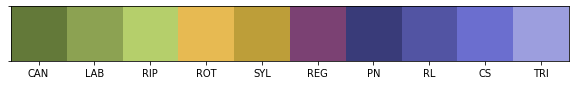

In [12]:
sample_names = data_neg.cdl.samples
all_labels = data_neg.cdl.labels
unique_labels = data_neg.cdl.unique_labels
print(unique_labels)
# customize these colors
colours = sns.color_palette('tab20b', 20)
label_colors = {'REG': colours[16],
                'PN': colours[0],
                'RL': colours[1],
                'CS': colours[2],
                'TRI': colours[3],
                'CAN': colours[4],
                'LAB': colours[5],
                'RIP': colours[6],
                'ROT': colours[10],
                'RU': colours[8],
                'SYL': colours[9]}

#label_colors = {lbl: c for lbl, c in zip(unique_labels, colours)}

sns.palplot([label_colors[lbl] for lbl in unique_labels])
new_ticks = plt.xticks(range(len(unique_labels)), unique_labels)

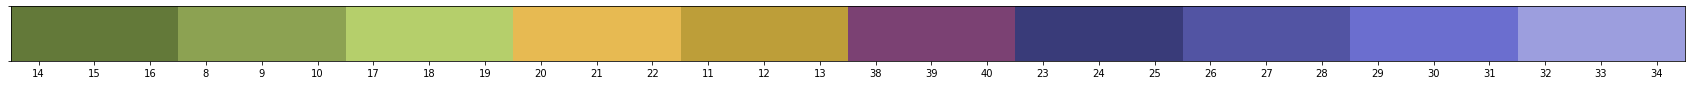

In [13]:
sample_colors = {s: label_colors[lbl] for s, lbl in zip(sample_names, all_labels)}

sns.palplot(sample_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

### Function to make all possible combinations of treatments between Normalization by a reference feature (N), Glog transformation (G) and Pareto Scaling (P).

Missing value imputation was always performed - Approach taken: Substitution by half of the minimum value in the dataset

8 combination of treatments:
- Just Missing Value Imputation (I)
- Missing Value Imputation and Pareto Scaling (P)
- Missing Value Imputation  and Normalization by  a reference feature (N)
- Missing Value Imputation  and Glog transformation (G)
- Missing Value Imputation, Normalization by  a reference feature and Pareto Scaling (NP)
- Missing Value Imputation, Glog transformation  and Pareto Scaling (GP)
- Missing Value Imputation, Normalization by  a reference feature and Glog transformation (NG)
- Missing Value Imputation, Normalization by  a reference feature, Glog transformation and Pareto Scaling (NGP)

Reference feature is Leucine Enkephalin

In [14]:
def compute_transf(dataset, norm_ref=None, remove_also=None, lamb=None):
    intensities = dataset
    
    #intensities = transf.keep_atleast(intensities, 3)
    
    dicto = {}
    imputed = transf.fillna_frac_min(intensities, fraction=0.5)
    
    if remove_also is not None:
        for feat in remove_also:
            imputed = transf.remove_feature(imputed, feat)

    N = transf.normalize_ref_feature(imputed, norm_ref, remove=False)
    #N = normalize_total(imputed)
    
    N = transf.remove_feature(N, norm_ref)

    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(N)
    
    NG = transf.glog(N, lamb=lamb)
    NGP = transf.pareto_scale(NG)
    #NGP = transf.auto_scale(NG)

    G = transf.glog(imputed, lamb=lamb) # Important
    GP = transf.pareto_scale(G) # Important
    
    dicto['I'] = imputed
    dicto['P'] = P
    dicto['N'] = N
    dicto['G'] = G
    dicto['NP'] = NP
    dicto['GP'] = GP
    dicto['NG'] = NG
    dicto['NGP'] = NGP
    
    return dicto

Performing the treatments

In [15]:
# Negative mode dataset
treat_neg = compute_transf(data_neg, norm_ref = 554.26202)

# Positive mode dataset
treat_pos = compute_transf(data_pos, norm_ref = 556.2765712820513)

df_neg = treat_neg['NGP']
df_pos = treat_pos['NGP']

## HCA

### Negative mode

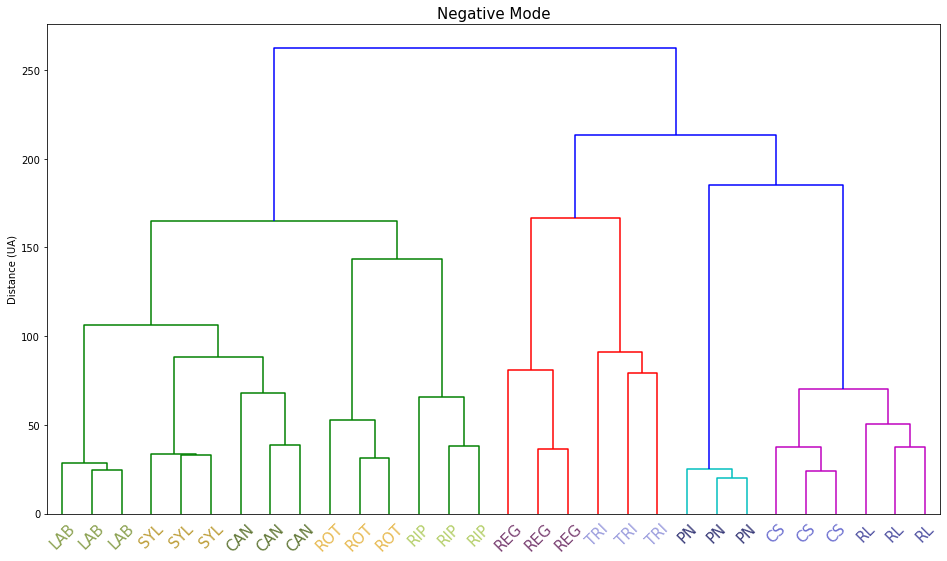

In [16]:
f, ax = plt.subplots(figsize=(16,9))
Z_neg = perform_HCA(df_neg, method='ward')

title = f'Negative Mode'
plot_dendogram(Z_neg, label_colors, title, ax=ax)
plt.savefig('dendro_neg.svg')

### Positive mode

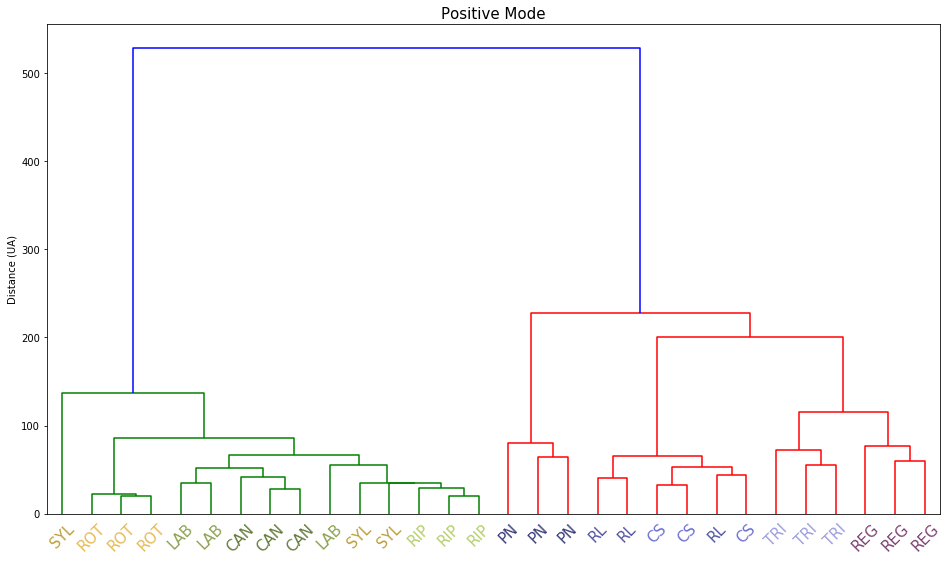

In [17]:
f, ax = plt.subplots(figsize=(16,9))
Z_pos = perform_HCA(df_pos, method='ward')

title = f'Positive Mode'
plot_dendogram(Z_pos, label_colors, title, ax=ax)
plt.savefig('dendro_pos.svg')

## PCA

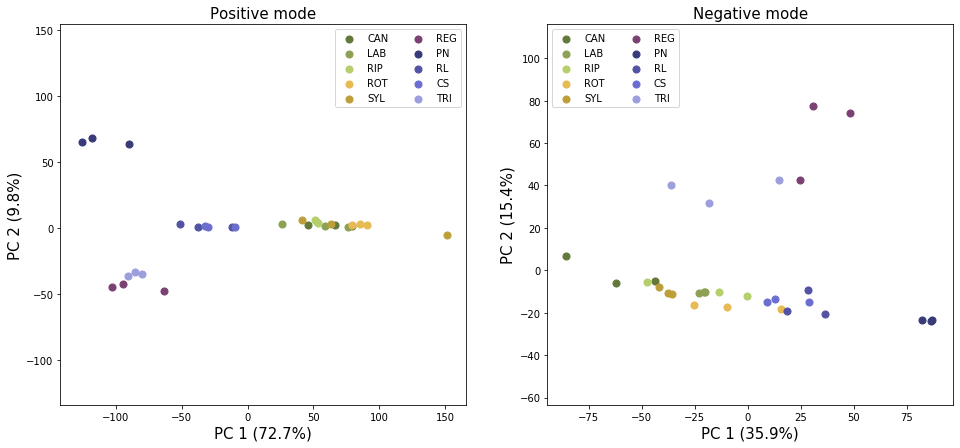

In [18]:
principaldf_neg, ve_neg = compute_df_with_PCs(df_neg, return_var_ratios=True)
principaldf_pos, ve_pos = compute_df_with_PCs(df_pos, return_var_ratios=True)

fig, (axl, axr) = plt.subplots(1,2, figsize=(16,7))
plot_PCA(principaldf_pos, label_colors, title="Positive mode", components=[1,2], ax=axl, var_explained=ve_pos)
axl.legend(loc='upper right', ncol=2)
plot_PCA(principaldf_neg, label_colors, title="Negative mode", components=[1,2], ax=axr, var_explained=ve_neg)
axr.legend(loc='upper left', ncol=2)

#principaldf_neg
plt.savefig('pca.svg')

## ANOVA and clustermap (by ANOVA p-values)

### Negative mode

In [19]:
df_p = sort_by_ANOVA_pvalues(df_neg, keep_only=50)

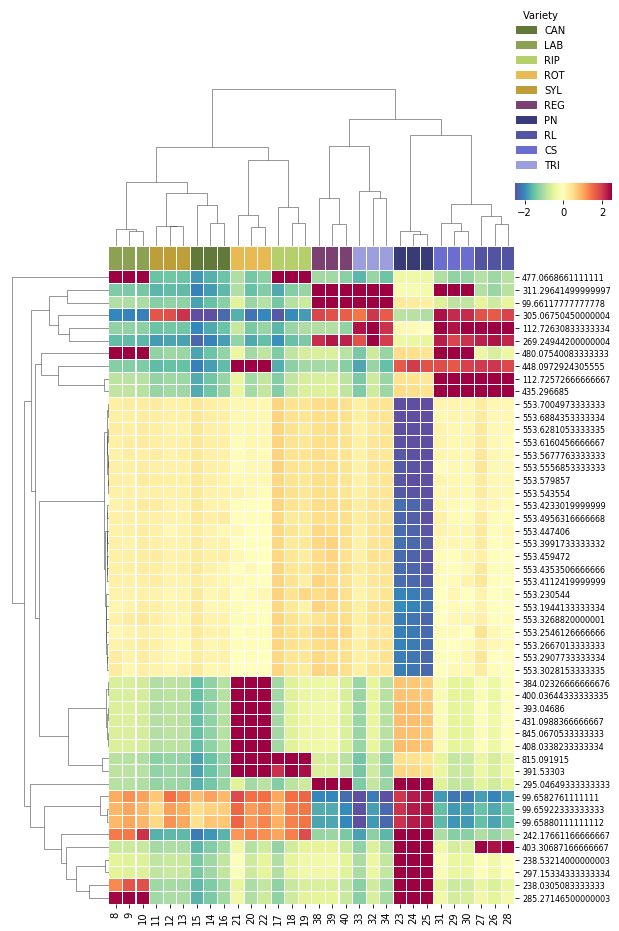

In [20]:
g = plot_clustermap(df_p, Z_neg, label_colors, legend_title='Variety')
g.savefig('neg_clustermap_pvalues.svg')

### Positive mode

In [21]:
df_p = sort_by_ANOVA_pvalues(df_pos, keep_only=50)

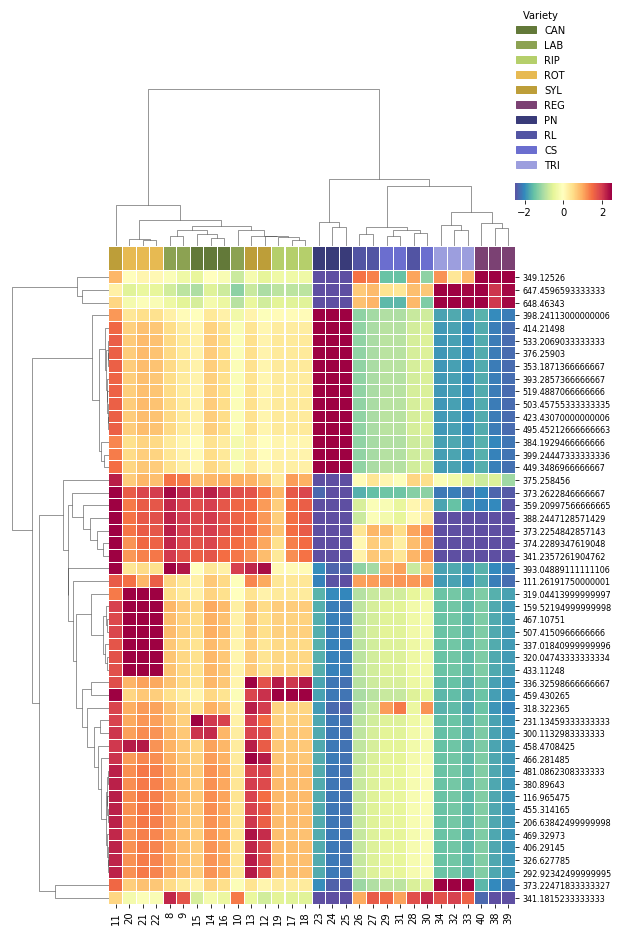

In [22]:
g = plot_clustermap(df_p, Z_pos, label_colors, legend_title='Variety')
g.savefig('pos_clustermap_pvalues.svg')

## PLS-DA - Classification based on Partial Least Squares - Discriminant Analysis

### Classifier into each Vitis cultivar

#### Sample projection on the 2 Principal Latent variables

#### Negative mode

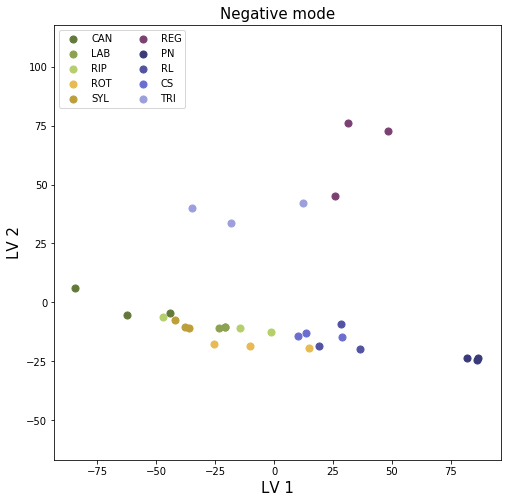

In [23]:
n_components = 15

plsreg_GPneg = ma.PLSscores_with_labels(df_neg, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PCA(plsreg_GPneg, label_colors, title="Negative mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.savefig('plsda_neg.svg')

#### Positive Mode

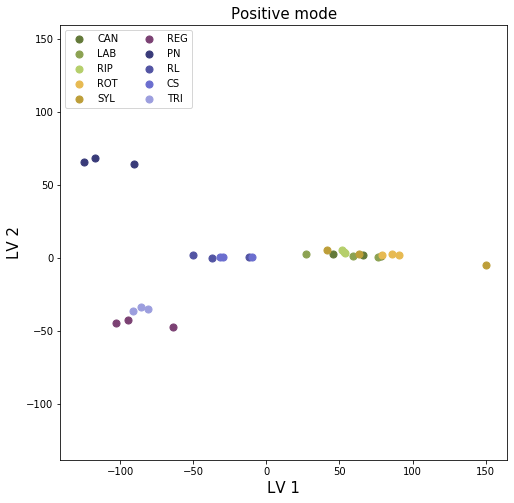

In [24]:
n_components = 15

plsreg_GPpos = ma.PLSscores_with_labels(df_pos, n_components)

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PCA(plsreg_GPpos, label_colors, title="Positive mode", ax=axl)
plt.legend(loc='upper left', ncol=2)
plt.savefig('plsda_pos.svg')

### PLS-DA optimization and accuracy tests for different number of components

### Not needed for figures since these models aren't even built with all samples - division between test and training samples

In [25]:
matrix = pd.get_dummies(all_labels)
matrix

,CAN,CS,LAB,PN,REG,RIP,RL,ROT,SYL,TRI
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,0,0,1,0,0


In [26]:
%%capture --no-stdout
accu_neg, score_neg, _, impfeatures_neg = ma.model_PLSDA(df_neg, n_comp=13, iter_num=100, feat_type='Coef')
accu_pos, score_pos, _, impfeatures_pos = ma.model_PLSDA(df_pos, n_comp=13, iter_num=100, feat_type='Coef')


## Clustermaps with top VIP scores

In [27]:
def df_by_vip(df, impfeats, keep_only=20, return_vips=False):
    dffeats = pd.DataFrame(impfeats, columns=['feat pos', 'importance', 'label'])
    dffeats = dffeats.set_index('feat pos')
    dffeats = dffeats.head(keep_only)
    df_vips = df.reindex(dffeats['label'].values)
    if return_vips:
        return (df_vips, dffeats['importance'].values)
    else:
        return df_vips

In [28]:
df_vips_neg = df_by_vip(df_neg, impfeatures_neg, keep_only=50)
df_vips_pos = df_by_vip(df_pos, impfeatures_pos, keep_only=50)
#df_vips_neg

### Negative mode

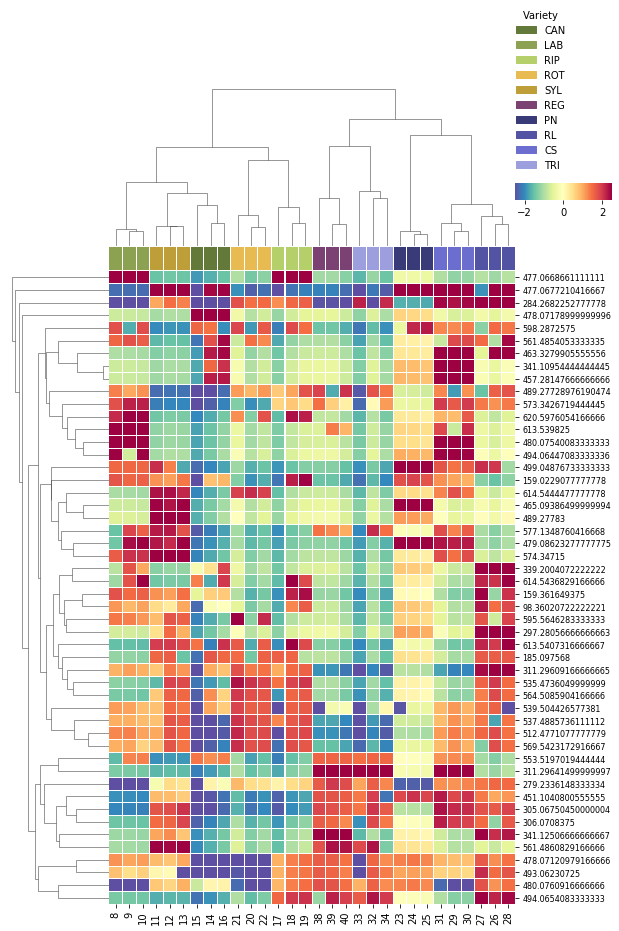

In [29]:
g = plot_clustermap(df_vips_neg, Z_neg, label_colors, legend_title='Variety')
g.savefig('neg_clustermap_vips.svg')

### Positive mode

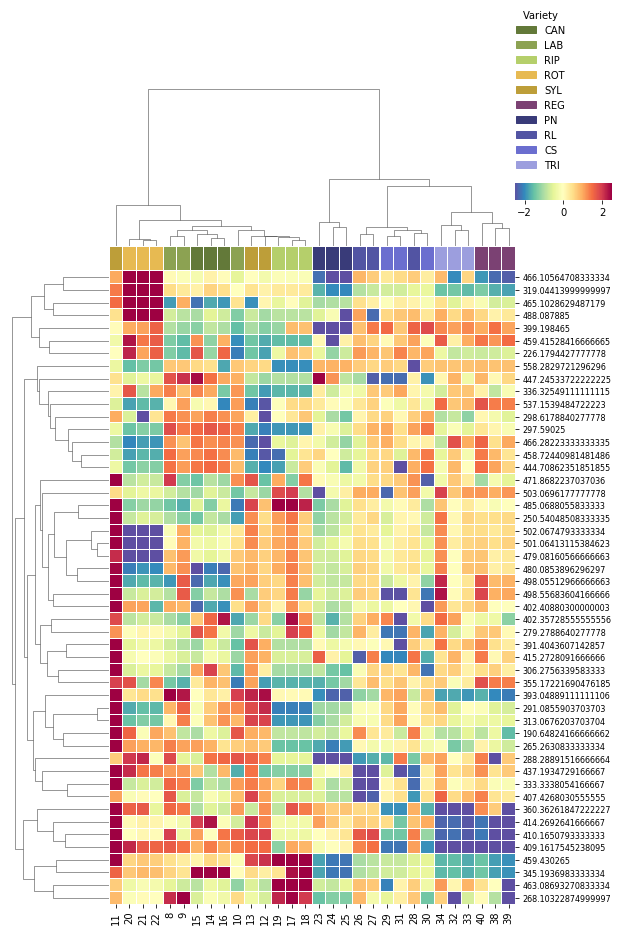

In [30]:
g = plot_clustermap(df_vips_pos, Z_pos, label_colors, legend_title='Variety')
g.savefig('pos_clustermap_vips.svg')

# PLS-DA Classifier for T/R vs S

In [31]:
# Make sure labels are correct
resistant = nonvin[:]
susceptible = vin[:]
# move REG
resistant.append('REG')
susceptible.remove('REG')
resistance_labels = ['R/T' if lbl in resistant else 'S' for lbl in all_labels]
resistance_trans = {lbl: rlbl for lbl, rlbl in zip(all_labels, resistance_labels)}
print(list(all_labels))
print(resistance_labels)
resistance_trans

['CAN', 'CAN', 'CAN', 'LAB', 'LAB', 'LAB', 'RIP', 'RIP', 'RIP', 'ROT', 'ROT', 'ROT', 'SYL', 'SYL', 'SYL', 'REG', 'REG', 'REG', 'PN', 'PN', 'PN', 'RL', 'RL', 'RL', 'CS', 'CS', 'CS', 'TRI', 'TRI', 'TRI']
['R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'R/T', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S']


{'CAN': 'R/T',
 'LAB': 'R/T',
 'RIP': 'R/T',
 'ROT': 'R/T',
 'SYL': 'R/T',
 'REG': 'R/T',
 'PN': 'S',
 'RL': 'S',
 'CS': 'S',
 'TRI': 'S'}

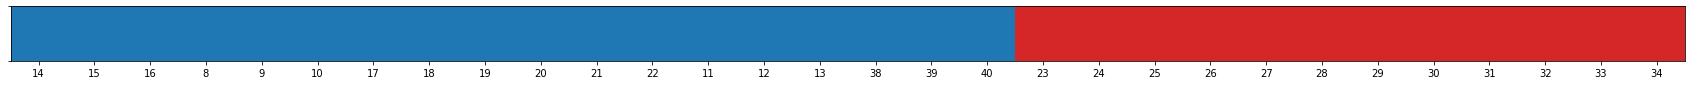

In [32]:
colours20 = sns.color_palette('tab20', 20)
resistance_colors = {'R/T':colours20[0], 'S':colours20[6]}

sample_res_colors = {s: resistance_colors[lbl] for s, lbl in zip(sample_names, resistance_labels)}

sns.palplot(sample_res_colors.values())
new_ticks = plt.xticks(range(len(sample_names)), sample_names)

### Projection over first two Latent variables

#### Negative mode

In [33]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

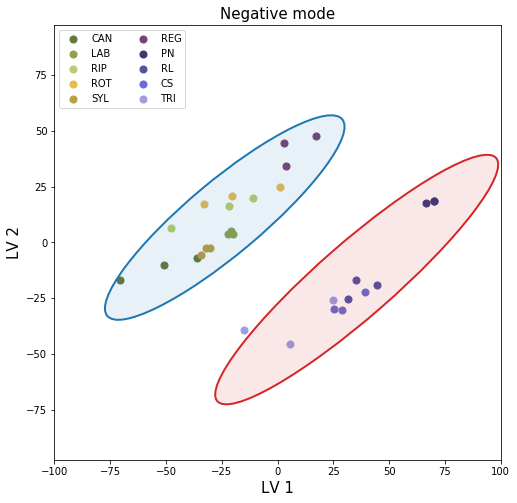

In [34]:
n_components = 15

plsreg_res_neg = ma.PLSscores_with_labels(df_neg, n_components, labels=resistance_labels)

# apply a transformation to plot original label colors
plsreg_res_neg = plsreg_res_neg.rename(columns={'Label': 'Resistance label'})
plsreg_res_neg['Label'] = all_labels

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PCA(plsreg_res_neg, label_colors, title="Negative mode", ax=axl)

for lbl in 'R/T', 'S':
    rcolor = resistance_colors[lbl]
    subset = plsreg_res_neg[plsreg_res_neg['Resistance label']==lbl]
    #scat = plt.scatter(subset[f'PC 1'], subset[f'PC 2'], s=100, label=lbl, linewidths=2, edgecolor=rcolor)
    #scat.set_facecolor('none')
    plot_confidence_ellipse(subset[['LV 1', 'LV 2']], nstd=2, edgecolor=rcolor, 
                            facecolor=rcolor, alpha=0.1)
    plot_confidence_ellipse(subset[['LV 1', 'LV 2']], nstd=2, edgecolor=rcolor, 
                            facecolor='none', lw=2)
    plt.ylim(-100, 100)
    plt.xlim(-100, 100)
    plt.legend(loc='upper left', ncol=2)

plt.savefig('plsda_neg_res.svg')

#### Positive mode

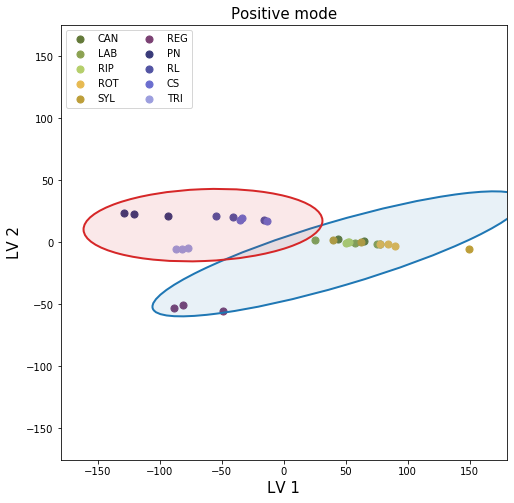

In [35]:
n_components = 15

plsreg_res_pos = ma.PLSscores_with_labels(df_pos, n_components, labels=resistance_labels)

# apply a transformation to plot original label colors
plsreg_res_pos = plsreg_res_pos.rename(columns={'Label': 'Resistance label'})
plsreg_res_pos['Label'] = all_labels

fig, axl = plt.subplots(1,1, figsize=(8,8))
plot_PCA(plsreg_res_pos, label_colors, title="Positive mode", ax=axl)

for lbl in 'R/T', 'S':
    rcolor = resistance_colors[lbl]
    subset = plsreg_res_pos[plsreg_res_pos['Resistance label']==lbl]
    #scat = plt.scatter(subset[f'PC 1'], subset[f'PC 2'], s=100, label=lbl, linewidths=2, edgecolor=rcolor)
    #scat.set_facecolor('none')
    plot_confidence_ellipse(subset[['LV 1', 'LV 2']], nstd=2, edgecolor=rcolor, 
                            facecolor=rcolor, alpha=0.1)
    plot_confidence_ellipse(subset[['LV 1', 'LV 2']], nstd=2, edgecolor=rcolor, 
                            facecolor='none', lw=2)
    plt.ylim(-180, 180)
    plt.xlim(-180, 180)
    plt.legend(loc='upper left', ncol=2)
    #plt.grid(True)

plt.savefig('plsda_pos_res.svg')

What would be a One-Hot encoding for this classifier?

In [36]:
matrix_r = pd.get_dummies(resistance_labels)
matrix_r

,R/T,S
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


## Fitting PLS-DA and cross-validation

In [37]:
PLS_df_neg = {}
PLS_df_pos = {}
n_fold_startifiedCV = 5

In [38]:
# not needed, labels are used and matrix computed
# matrix_r = pd.get_dummies(resistance_labels)

In [39]:
%%capture --no-stdout


for i in range(4,15):
    print(f'Fitting PLS-DA for the datasets with {i} components...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(df_neg, labels=resistance_labels,
                                                  n_fold=n_fold_startifiedCV, 
                                                  n_comp=i, iter_num=100, 
                                                  feat_type = 'Coef')
    PLS_df_neg[i] = np.mean(accu)
    accu, score, u, imp_features = ma.model_PLSDA(df_pos, labels=resistance_labels,
                                                  n_fold=n_fold_startifiedCV,
                                                  n_comp=i, iter_num=100, 
                                                  feat_type = 'Coef')
    PLS_df_pos[i] = np.mean(accu)
    print(f'done')   

Fitting PLS-DA for the datasets with 4 components...done
Fitting PLS-DA for the datasets with 5 components...done
Fitting PLS-DA for the datasets with 6 components...done
Fitting PLS-DA for the datasets with 7 components...done
Fitting PLS-DA for the datasets with 8 components...done
Fitting PLS-DA for the datasets with 9 components...done
Fitting PLS-DA for the datasets with 10 components...done
Fitting PLS-DA for the datasets with 11 components...done
Fitting PLS-DA for the datasets with 12 components...done
Fitting PLS-DA for the datasets with 13 components...done
Fitting PLS-DA for the datasets with 14 components...done


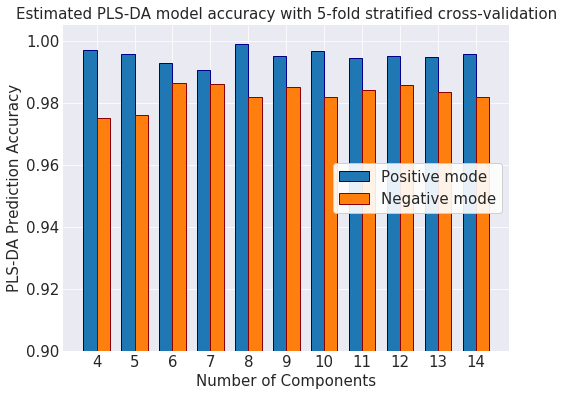

In [40]:
# for line plots...
#plt.plot(list(PLS_df_neg.keys()), list(PLS_df_neg.values()), label='Negative mode')
#plt.plot(list(PLS_df_pos.keys()), list(PLS_df_pos.values()), label='Positive mode')

with plt.style.context('seaborn-darkgrid'):
    f, ax = plt.subplots(figsize=(8,6))
    labels = list(PLS_df_neg.keys())
    pos_values = list(PLS_df_pos.values())
    neg_values = list(PLS_df_neg.values())

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = ax.bar(x-width*0.5, pos_values, width, label='Positive mode', ec='darkblue')
    rects2 = ax.bar(x+width*0.5, neg_values, width, label='Negative mode', ec='darkred')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    plt.ylabel('PLS-DA Prediction Accuracy', fontsize = 15)
    plt.xlabel('Number of Components', fontsize = 15)
    ax.legend(fontsize = 15, loc=5, frameon=True, framealpha=0.9, facecolor='white')
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.title('Estimated PLS-DA model accuracy with 5-fold stratified cross-validation', fontsize=15)
    plt.ylim(0.9, 1.005)


### Permutation tests

In [41]:
all_data = (df_pos, df_neg)
names = ('Positive mode', 'Negative mode')

CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=12, labels=resistance_labels,
                                   n_fold=n_fold_startifiedCV, iter_num=500)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for Positive mode ...
Done!
permutation test (PLS-DA) for Negative mode ...
Done!


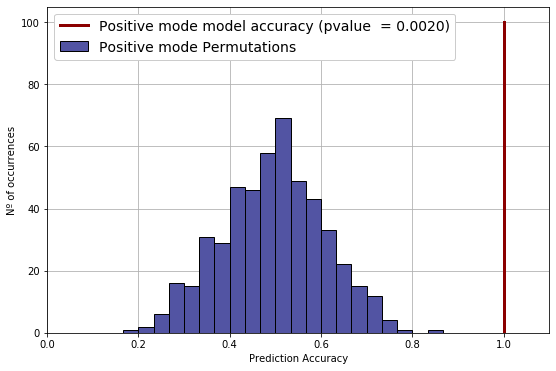

In [43]:
f, ax = plt.subplots(figsize = (9,6))

ylim = [0,100]

ax.hist(PMs_PLS['Positive mode'], 30, range=(0, 1.0001), label='Positive mode Permutations',
         edgecolor='black', color=colours[1])
    
ax.plot(2 * [CV_PLS['Positive mode']], ylim, '-', linewidth=3, color='darkred', #alpha = 0.5,
             label='Positive mode model accuracy' + ' (pvalue  = %.4f)' % pvalue_PLS['Positive mode'])

ax.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
ax.set_xlim(0, 1.1)
ax.set_axisbelow(True)
ax.grid(True)
leg = ax.legend(fontsize=14, framealpha=1)

plt.savefig('permutations_pos.svg')

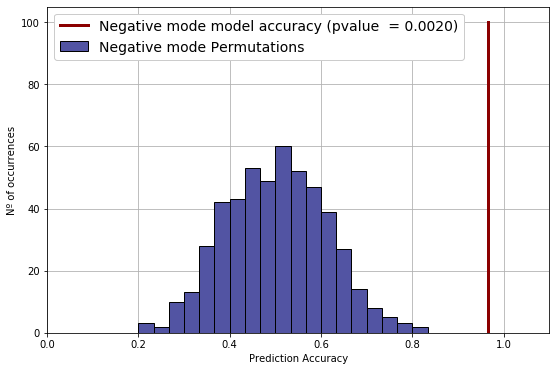

In [44]:
f, ax = plt.subplots(figsize = (9,6))

ylim = [0,100]

ax.hist(PMs_PLS['Negative mode'], 30, range=(0, 1.0001), label='Negative mode Permutations',
         edgecolor='black', color=colours[1])
    
ax.plot(2 * [CV_PLS['Negative mode']], ylim, '-', linewidth=3, color='darkred', #alpha = 0.5,
             label='Negative mode model accuracy' + ' (pvalue  = %.4f)' % pvalue_PLS['Negative mode'])
ax.set(xlabel='Prediction Accuracy', ylabel='Nº of occurrences')
ax.set_xlim(0, 1.1)
ax.set_axisbelow(True)
ax.grid(True)
leg = ax.legend(fontsize=14, framealpha=1)

plt.savefig('permutations_neg.svg')